In [1]:
###############################################
# this notebooks runs the DAIS algorithm on the target distribution
# pi(x, y) \propto exp(-U(x, y))
# where:
# U(x, y)= (1/2) * ( x**2 + (y - func(x))**2/SD_TARGET**2 )
# func(x) = 0.5 * sin(2 * pi * x)
###############################################
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.random as jr
import jax.numpy as jnp
import pylab as plt
import numpy as np
import matplotlib.pyplot as plt

# local imports
import sys
sys.path.append('../')

from util.ellipse import plot_ellipse
from dais.DAIS import DAIS as DAIS
from dais.proba.density import LogDensityGeneral

In [2]:
# initialize random number generator
key = jr.key(0)

In [3]:
# create the target distribution
dim = 2
SD_TARGET = 0.1

def func(x):
    return 1.+jnp.sin(2*x)

def log_target_density(z):
    x,y = z[0], z[1]
    return -0.5*x**2 -0.5*y**2 - 0.5*(y - func(x))**2/SD_TARGET**2

# log_target_density_batch = jax.jit(jax.vmap(log_target_density))

def sample(key, n_samples):
    """ generate iid samples from the target distribution """
    key, key_ = jr.split(key)
    x = jr.normal(key_, (n_samples,))
    key, key_ = jr.split(key)
    y = func(x) + SD_TARGET*jr.normal(key_, (n_samples,))
    return jnp.concatenate([x[:,None], y[:,None]], axis=1)

In [4]:
logdensity = LogDensityGeneral(
                logdensity=log_target_density,
                sample=sample,
                dim=dim)

In [5]:
# compute empirical mean // covariance from iid sampled
S = 10**6
key, key_ = jr.split(key)
S =10**6
xs = logdensity.sample(key, S)
mu_target = np.mean(xs, axis=0)
Gamma_target = np.cov(xs, rowvar=False)

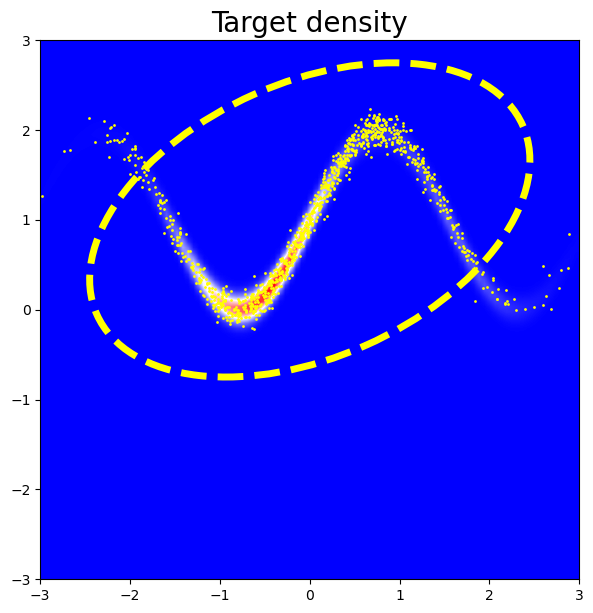

In [6]:
# plot the target distribution
mx, Mx = -3,3
my, My = -3,3
N = 100
X0,X1 = np.meshgrid(
            np.linspace(mx,Mx ,N),
            np.linspace(my,My,N),
            )
X = np.concatenate([X0[:,:,None], X1[:,:,None]], axis=2)
Z = logdensity.batch(X.reshape(N**2,-1))
Z = np.exp(Z.reshape(N,N))

fig, ax = plt.subplots(1, 1, figsize=(7,7))

# plot density
plt.imshow(Z, origin="lower", interpolation="bilinear", 
           extent=[mx,Mx,my,My], cmap="bwr")

# plot samples
N_to_plot = 1000
plt.scatter(xs[:N_to_plot,0], xs[:N_to_plot,1], s=1, color="yellow")
plt.xlim(mx,Mx)
plt.ylim(my,My)

plt.title("Target density", fontsize=20)

plot_ellipse(ax, mu_target, Gamma_target,
             color="yellow", linestyle="--", lw=5)

In [7]:
# initial mean/covariance
mu_init = np.zeros(dim)
Gamma_init = np.eye(dim)

# number of smaples and number of iterations
n_samples = 100_000
n_iter = 50

# Effective Sample size threshold
ESS_threshold = 0.1
    
# initialize the method
dais = DAIS(logtarget=logdensity)

# run the method
key, key_ = jr.split(key)
output_dict = dais.run(
                key = key_,
                mu_init = mu_init,
                cov_init = Gamma_init,
                n_samples = n_samples,
                n_iter = n_iter,
                ess_threshold = ESS_threshold,
                c_robust = 0.1,
                verbose = True)

[00001/50] 	 eps: 0.68 	 ELBO: -123.43 	 ESS: 0.083
[00002/50] 	 eps: 0.75 	 ELBO: -113.66 	 ESS: 0.087
[00003/50] 	 eps: 0.83 	 ELBO: -105.15 	 ESS: 0.091
[00004/50] 	 eps: 0.91 	 ELBO: -98.18 	 ESS: 0.095
[00005/50] 	 eps: 0.97 	 ELBO: -90.45 	 ESS: 0.099
[00006/50] 	 eps: 1.00 	 ELBO: -84.11 	 ESS: 0.104
[00007/50] 	 eps: 1.00 	 ELBO: -79.19 	 ESS: 0.107
[00008/50] 	 eps: 1.00 	 ELBO: -74.79 	 ESS: 0.108
[00009/50] 	 eps: 1.00 	 ELBO: -70.96 	 ESS: 0.111
[00010/50] 	 eps: 1.00 	 ELBO: -67.03 	 ESS: 0.114
[00011/50] 	 eps: 1.00 	 ELBO: -64.08 	 ESS: 0.117
[00012/50] 	 eps: 1.00 	 ELBO: -61.14 	 ESS: 0.118
[00013/50] 	 eps: 1.00 	 ELBO: -59.15 	 ESS: 0.119
[00014/50] 	 eps: 1.00 	 ELBO: -56.95 	 ESS: 0.118
[00015/50] 	 eps: 1.00 	 ELBO: -55.03 	 ESS: 0.120
[00016/50] 	 eps: 1.00 	 ELBO: -53.76 	 ESS: 0.118
[00017/50] 	 eps: 1.00 	 ELBO: -51.91 	 ESS: 0.118
[00018/50] 	 eps: 1.00 	 ELBO: -50.77 	 ESS: 0.117
[00019/50] 	 eps: 1.00 	 ELBO: -49.95 	 ESS: 0.120
[00020/50] 	 eps: 1.00 	 ELB

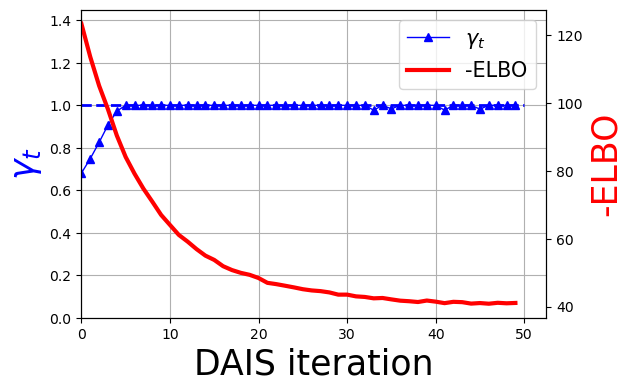

In [8]:
fig, ax_left = plt.subplots(figsize=(6,4))
ax_right = ax_left.twinx()

# display epsilon
plot_eps = ax_left.plot(output_dict["eps_traj"], "-^", lw=1, color='blue', label=r"$\gamma_t$")
ax_left.plot([0, len(output_dict["eps_traj"])], [1,1], "--", lw=2, color='blue')
ax_left.set_ylim(0,1.45)
ax_left.set_xlim(left=0)
ax_left.set_ylabel(r"$\gamma_t$", fontsize=25, color="blue")
ax_left.set_xlabel("DAIS iteration", fontsize=25)
ax_left.grid(True, which="major")

# display -ELBO
plot_elbo = ax_right.plot(-np.array(output_dict["elbo_traj"]),
                color='red', label="-ELBO", lw=3)
ax_right.set_ylabel("-ELBO", fontsize=25, color="red")

# added these three lines
lns = plot_eps + plot_elbo
labs = [l.get_label() for l in lns]
ax_left.legend(lns, labs, loc=1, fontsize=25)

# added these three lines
lns = plot_eps + plot_elbo
labs = [l.get_label() for l in lns]
ax_left.legend(lns, labs, loc=1, fontsize=15)

plt.savefig("banana_monitor.pdf", dpi=200, bbox_inches='tight')

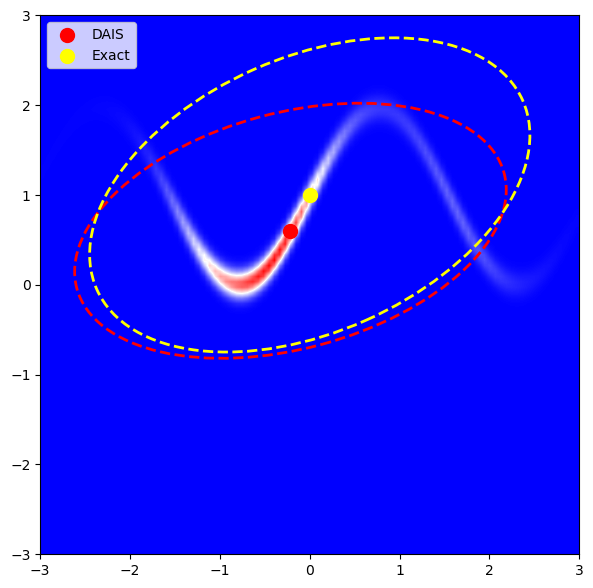

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.imshow(
        Z, origin="lower",
        interpolation="bilinear",
        extent=[mx,Mx,my,My],
        cmap="bwr")

mu = output_dict["mu"]
Gamma = output_dict["cov"]

# DAIS approx
plot_ellipse(ax, mu, Gamma, color="red", linestyle="--", lw=2)
plt.scatter(mu[0], mu[1], s=100, color="red", label="DAIS")

# exact target
plot_ellipse(ax, mu_target, Gamma_target, color="yellow", linestyle="--", lw=2)
plt.scatter(mu_target[0], mu_target[1], s=100, color="yellow", label="Exact")

plt.legend()